Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 2: Logistic Regression

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

This notebook is structured as follows:<br>
[Part 1 - Logistic Regression](#Part1)
1. [Exploratory Data Analysis](#eda)
2. [Developing Sigmoid, Cost, and Gradient Functions](#funcs)
3. [Finding the Optimal Model Parameters](#opt)
4. [Plotting the Decision Boundary](#plot)
5. [Model Evaluation](#metrics)
6. [Implementing Logistic Regression with sklearn](#sklearn)

[Part 2 - Regularized Logistic Regression with Non-linear Features](#Part2)
1. [Exploratory Data Analysis](#eda2)
2. [Polynomial Feature Generation](#fg)
3. [Adding Regularization to Cost and Gradient Functions](#reg)
4. [Finding the Optimal Model Parameters](#opt2)
5. [Non-linear Logistic Regression with sklearn](#sklearn2)
6. [Tuning the Regularization Strength](#rs)
7. [Polynomial Degree and Overfitting](#pdo)

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example

import scipy.optimize as opt
from sympy.solvers import solve
from sympy import Symbol
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

<a id="Part1"></a>
# Part 1 - Logistic Regression

Prompt:<br>
Build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams.

***

To be clear, this is not really a "regression" problem. But rather we are faced with a binary classification problem: accept or reject the studen't application. The twist is that we are asked to determine each applicant's chance (probability) of acceptance. For this type of problem, a logistic classifier is actually a regression (the sigmoid function) between two cases (0 or 1 - reject or accept) and the crossover between these two cases gives us the probability associated with acceptance.

OK. Let's dive into the data and begin building the frameworks for logistic regression.

<a id="eda"></a>
# Exploratory Data Analysis

In [2]:
#Load the data into a pandas DataFrame
data = pd.read_csv('ex2/ex2data1.txt', header=None, names=['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
exam1       100 non-null float64
exam2       100 non-null float64
admitted    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
exam1,100.0,65.644274,19.458222,30.058822,50.919511,67.032988,80.212529,99.827858
exam2,100.0,66.221998,18.582783,30.603263,48.179205,67.682381,79.360605,98.869436
admitted,100.0,0.600000,0.492366,0.000000,0.000000,1.000000,1.000000,1.000000


We can see that 60% of the students were accepted

In [5]:
#use boolean masking to look separate data of accepted and rejected applicants
data[data.admitted==0].describe().T

,count,mean,std,min,25%,50%,75%,max
exam1,40.0,52.032301,17.549050,30.058822,35.707085,50.410642,61.928323,95.861555
exam2,40.0,54.620392,16.081591,30.603263,42.808798,49.698756,63.594638,98.869436
admitted,40.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
#use boolean masking to look separate data of accepted and rejected applicants
data[data.admitted==1].describe().T

,count,mean,std,min,25%,50%,75%,max
exam1,60.0,74.718923,14.912420,40.457551,63.597244,75.436657,84.675745,99.827858
exam2,60.0,73.956402,16.012403,43.390602,65.409676,74.753748,87.442625,97.718692
admitted,60.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Not very shocking, but students who were accepted had on average, significantly higher exame scores.

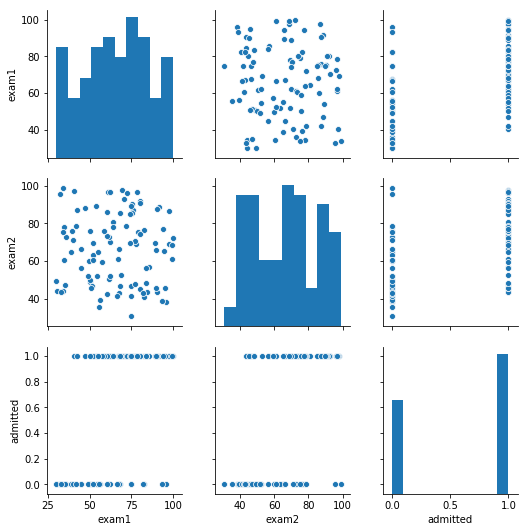

In [7]:
sns.pairplot(data)

That doesn't look as helpful does it? But actually, pay close attention to the exam1 vs. admitted scatter-plot. This looks almost exactly like a text book logistic regression problem. Let's look at the data a slightly different way

In [8]:
accepted = data[data.admitted==1]
rejected = data[data.admitted==0]

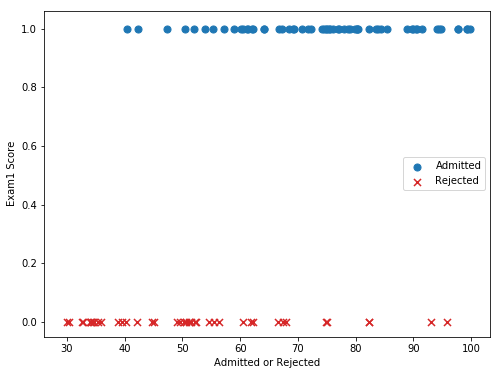

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(accepted.exam1, accepted.admitted, s=50, color=cp[0], label='Admitted')
ax.scatter(rejected.exam1, rejected.admitted, s=50, color=cp[3], marker='x', label='Rejected')
ax.set_xlabel('Admitted or Rejected')
ax.set_ylabel('Exam1 Score')
ax.legend()

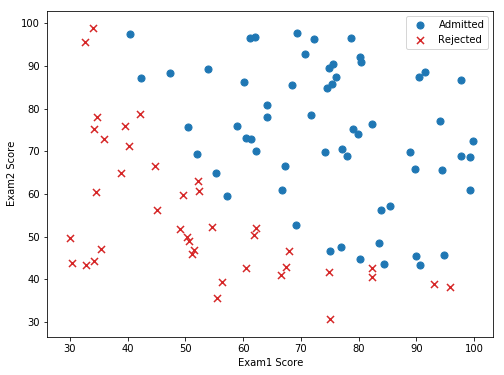

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(accepted.exam1, accepted.exam2, s=50, color=cp[0], label='Admitted')
ax.scatter(rejected.exam1, rejected.exam2, s=50, color=cp[3], marker='x', label='Rejected')
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
ax.legend()

We can actually do something slighly fancier with seaborn's pairpolot.

In [11]:
#have to cast the data into a 'category' type to get it to plot with seaborn's pairplot
data.iloc[:,-1] = data.iloc[:,-1].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
exam1       100 non-null float64
exam2       100 non-null float64
admitted    100 non-null category
dtypes: category(1), float64(2)
memory usage: 1.8 KB


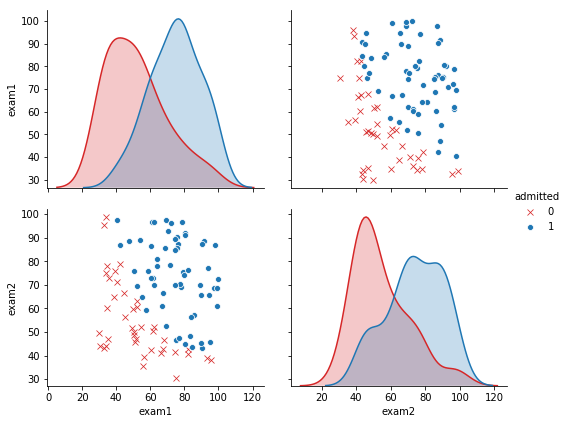

In [12]:
sns.pairplot(data, vars=["exam1", "exam2"], hue="admitted", \
             palette={0:cp[3], 1:cp[0]}, height=3, aspect=1.2, markers=["x", "o"])

In [13]:
#have to cast the data back to int type
data.iloc[:,-1] = data.iloc[:,-1].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
exam1       100 non-null float64
exam2       100 non-null float64
admitted    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


<a id="funcs"></a>
# Developing Sigmoid, Cost, and Gradient Descent Functions
Let's start by looking at the sigmoid or logit function

### The Sigmoid Function

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
#notice that in this form it can be used on an array or on individual numbers

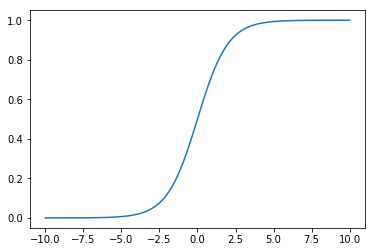

In [15]:
#Let's plot what that looks like
x = np.linspace(-10,10,num=100)
sig = [sigmoid(i) for i in x] # isn't list comprehension nice?
plt.plot(x,sig)

Let's write our cost function next.

### The Cost Function For Logistic Regression

In [16]:
def Cost(theta, X, y):
    """ Calculates the cost function for logistic regression
    input
    theta: a numpy array of length n; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable

    output
    cost: the sum of the ordinary least squares over all the data
    """
    theta = np.matrix(theta) # convert numpy array to matrix for matrix multiplications
    
    M = len(X)
        
    hyp = sigmoid(X * theta.T)
    
    c = np.multiply(-y, np.log(hyp)) - np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(c) / (M)



We will need to make sure we keep careful track of the matrix shapes when we calculate the cost. We'll get into this in more detail later, but here we want the initialized $\theta$ to be a numpy array of length $n$. This is because the scipy optimizing functions wants an array not a matrix. So we need to convert $\theta$ to a matrix in our Cost and Gradient functions.

In [17]:
# convert the features from the DataFrame into a numpy matrix
X = np.matrix(data.iloc[:,:-1])

# add the bias column
X = np.insert(X, 0, np.ones(len(X)), axis=1)   

# convert the target variables from the DataFrame into a numpy matrix
y = np.matrix(data.iloc[:,-1]).T 

#Initialize theta
theta = np.zeros(X.shape[1])

X.shape, y.shape, theta.shape

((100, 3), (100, 1), (3,))

In [18]:
X[:5]

matrix([[ 1.        , 34.62365962, 78.02469282],
        [ 1.        , 30.28671077, 43.89499752],
        [ 1.        , 35.84740877, 72.90219803],
        [ 1.        , 60.18259939, 86.3085521 ],
        [ 1.        , 79.03273605, 75.34437644]])

In [19]:
Cost(theta, X, y)

0.6931471805599453

Great! Cost function is working since we have matched the $X$, $y$, and $\theta$ matrix dimensions carefully with out matrix multiplications in the cost function. 

### The Gradient Function For Logistic Regression

Next, we are asked to write the gradient function.  In the linear regression example, we manually implemented gradient descent. Here we are asked to use a function optimizer (`fminunc` in Octave). In that case, we need to simply write a function that calculates the gradient and then let the function optimizer (i.e. minimizer) do the heavy lifting. In python we'll use scipy.optimize API (see: [scipy's Optimization page](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) and [scipy.optmize documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize)). A key thing to remember here is that the parameters which we want to find the optimal values for (in this case theta) should be the __FIRST__ argument of the function. Notice that I wrote the cost function with the same convention. 

In [20]:
def Gradient(theta, X, y):
    """ Calculates the gradient of the logistic regression cost function 
    input
    theta: a 1 x n matrix; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    
    output
    gradient: a numpy array of floats of lenth n
    """
    M=len(X)
    theta=np.matrix(theta)
    parameters = int(theta.shape[1])
    grad = np.zeros(parameters)
        
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        grad[i] = np.sum(np.multiply(error, X[:,i])) / M
    
    return grad

In [21]:
Gradient(theta,X,y)

array([ -0.1       , -12.00921659, -11.26284221])

<a id="opt"></a> 
# Finding the Optimal Model Parameters 

Excellent! We have a working function that calculates the gradient. Now we need to call a function optimizer (minimizer) from scipy. For this problem, we'll use `fmin_trunc`. Here is a snippet from the `opt.fmin_tnc` documentation: `"Minimize a function with variables subject to bounds, using gradient information in a truncated Newton algorithm. ... The underlying algorithm is truncated Newton, also called Newton Conjugate-Gradient. The algorithm incorporates the bound constraints by determining the descent direction as in an unconstrained truncated Newton, but never taking a step-size large enough to leave the space of feasible x's. ..."`

Look carefully at the documentation arguments in more detail to get a better feel for why they are being called and why we wrote the Cost and Gradient functions the way we did.

In [22]:
result = opt.fmin_tnc(func=Cost, x0=theta, fprime=Gradient, args=(X, y))
result

(array([-25.16131866,   0.20623159,   0.20147149]), 36, 0)

In [23]:
Cost(result[0], X, y)

0.20349770158947444

Just like that we've found the optimal logistic regression parameters for this data set. -25.16 is the bias term, while 0.206 and 0.201 represent the linear components for exam1 and exam2, respectively. 

Alternatively, we could have used the more flexible `optimize.minimize` function from scipy. 

In [24]:
result = opt.minimize(fun=Cost, x0=theta, args=(X,y), method='TNC', jac=Gradient)
result

     fun: 0.20349770158947444
     jac: array([9.01534233e-09, 8.69256070e-08, 4.80499281e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131866,   0.20623159,   0.20147149])

In [25]:
result.x

array([-25.16131866,   0.20623159,   0.20147149])

In [26]:
Cost(result.x, X, y)

0.20349770158947444

Awesome! It may be fun for yourself to play around with different optimizers and see how long it takes for scipy to converge on a solution. With the logistic cost function some solvers won't perform as well and will spit out some warnings. 

So it seems like we have the optimal model parameters, but it would be nice to visualize the boundary.
<a id="plot"></a> 
# Plotting the Decision Boundary

In [27]:
def linear_boundary(weights,xmin,xmax):
    
    x1 = np.linspace(xmin,xmax,num=4)
    x2 = np.zeros(len(x1))
    x0 = np.ones(len(x1))

    x = Symbol('x')
    e = 2.71828
    c = weights[2]

    for index, value in enumerate(x1):
        a = weights[0]*x0[index]
        b = weights[1]*x1[index]
        result = solve(a + b + weights[2]*x, x)
        x2[index] = result[0]

    return x1, x2

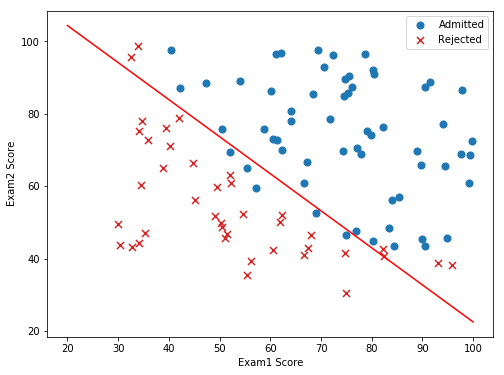

In [28]:
x1,x2 = linear_boundary(result.x,20,100)


fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(accepted.exam1, accepted.exam2, s=50, color=cp[0], label='Admitted')
ax.scatter(rejected.exam1, rejected.exam2, s=50, color=cp[3], marker='x', label='Rejected')
ax.plot(x1,x2, color='red')
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
ax.legend()

Look's pretty good, maybe it would be better to have a non-linear boundary, but in logistic regression this would require generating non-linear features (feature engineering). But it "seems" like a linear boundary is doing OK here. But can we quantify it? Of course we can. We're talking about measures like accuracy, precision, recall, and f1 score. To get these, we first need to find the predicted results of our model.
<a id="metrics"></a> 
# Model Evaluation

In [29]:
def predict(theta, X):
    proba = sigmoid(X * theta.T)
    prediction = [1 if x >= 0.5 else 0 for x in proba]
    return prediction

In [30]:
best_fit_params = np.matrix(result.x)
lr_predictions = predict(best_fit_params, X)

We could calculate our own accuracy, etc... metrics by calculating the number of true positives, etc..., but I'm lazy, and sklearn can do this for you!

In [31]:
def get_metrics(y_data, y_pred):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_data, y_pred)
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_data, y_pred)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_data, y_pred)
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_data, y_pred)
    return accuracy, precision, recall, f1

In [32]:
acc, prec, rec, f1 = get_metrics(y, lr_predictions)

In [33]:
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))
print(' ')

 
Accuracy: 0.89; Precision: 0.9; Recall: 0.92; F1 Score: 0.91
 


In [34]:
conf = confusion_matrix(y, lr_predictions)
print(conf)
#OK. so we printed a confusion matrix. But it would be nicer to plot it

[[34  6]
 [ 5 55]]


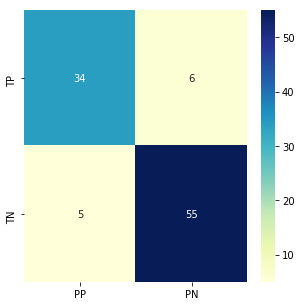

In [35]:
# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

The accuracy is 89%, which is not horrible and from looking at the confusion matrix, it seems that we are pretty well balanced between choosing false positives and false negatives. You can see this directly from how the logistic regression boundary slices through the data in the 2D scatter plot. 

<a id="sklearn"></a> 
# Implementing Logistic Regression with sklearn

In [36]:
# convert the features from the DataFrame into a numpy matrix
X = np.matrix(data.iloc[:,:-1])

# convert the target variables from the DataFrame into a numpy matrix
y = np.array(data.iloc[:,-1]).T 

X.shape, y.shape

((100, 2), (100,))

In [37]:
# create the LogisticRegression classifier object 
clf = LogisticRegression(C=1000, solver='newton-cg').fit(X, y)
clf.intercept_, clf.coef_

(array([-25.16109754]), array([[0.20622982, 0.20146969]]))

Here I used a very large inverse regulatization parameter (C=1000). The LogisticRegression algorithm has regularization built into it and the default parameter (C=1) provides some finite regularization (L2 with the newton-cg solver). Since we want to compare with the home-made solution above, we want to get rid of the regularization. Also, I set fit_intercept to False (the default it True) because we have already manually inserted the bias term into the $X$ matrix.

Next, let's get the predictions of the classifier on the data and then check the metrics. Since the classifier coefficients are nearly identical to our home-made solution, we should expect the same accuracy results.

In [38]:
y_pred = clf.predict(X)
acc, prec, rec, f1 = get_metrics(y, y_pred)
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))
print(' ')

 
Accuracy: 0.89; Precision: 0.9; Recall: 0.92; F1 Score: 0.91
 


<a id="Part2"></a> 
# Part 2 - Regularized Logistic Regression with Non-linear Features 
Prompt:<br>
Implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.
<a id="eda2"></a>
# Exploratory Data Analysis

In [39]:
#Load the data into a pandas DataFrame
data = pd.read_csv('ex2/ex2data2.txt', header=None, names=['test1', 'test2', 'accepted'])
data.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
accepted    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [41]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
test1,118.0,0.054779,0.496654,-0.83007,-0.372120,-0.006336,0.478970,1.0709
test2,118.0,0.183102,0.519743,-0.76974,-0.254385,0.213455,0.646562,1.1089
accepted,118.0,0.491525,0.502060,0.00000,0.000000,0.000000,1.000000,1.0000


In [42]:
#use boolean masking to look separate data of accepted and rejected applicants
accepted = data[data.accepted==1]
rejected = data[data.accepted==0]

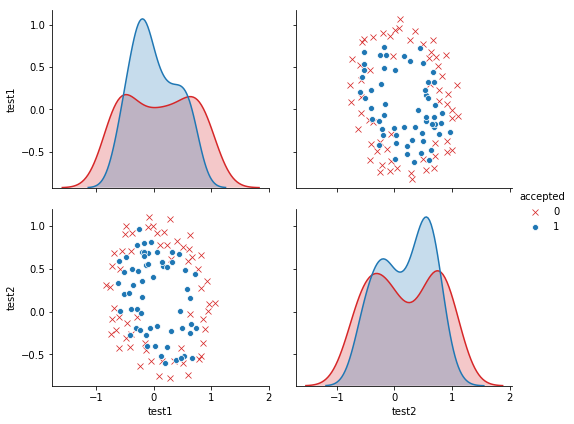

In [43]:
#have to cast the data into a 'category' type to get it to plot with seaborn's pairplot
data.iloc[:,-1] = data.iloc[:,-1].astype('category')

sns.pairplot(data, vars=["test1", "test2"], hue="accepted", \
             palette={0:cp[3], 1:cp[0]}, height=3, aspect=1.2, markers=["x", "o"])

In [44]:
# cast the data back to int type
data.iloc[:,-1] = data.iloc[:,-1].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
accepted    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


The data clearly has more structure and we can see that a linear boundary between the two variables will not provide a good model. So we need to generate non-linear features (i.e test1$\times$test2, test1$^2$, and test2$^2$ at the very least). When generating non-linear features, it's ALWAYS a good idea to include regulatization. 
<a id="fg"></a>
# Polynomial Feature Generation

Conveniently, sklearn provides a function which automatically generates nonlinear features for you! Sensing a theme? sklearn is amazingly well-designed for machine learning problems.

In [45]:
X = np.matrix(data.iloc[:,:-1])

poly = PolynomialFeatures(6)
X = poly.fit_transform(X)

# convert the target variables from the DataFrame into a numpy matrix
# notice that for the Gradient and Cost functions, this NEEDS TO BE A MATRIX mx1
# (for sklearn, it needs to be an array of length m)
y = np.matrix(data.iloc[:,-1]).T 

#Initialize theta
theta = np.zeros(X.shape[1])

X.shape, y.shape, theta.shape

((118, 28), (118, 1), (28,))

In [46]:
#let's just look at it quickly. 
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


<a id="reg"></a>
# Adding Regularization to Cost and Gradient Functions

In [47]:
def Regularized_Cost(theta, X, y, reg_scale):
    """ Calculates the regularized cost function for logistic regression
    input
    theta: a numpy array of length n; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    reg_scale: a float; strength of the regularization

    output
    cost: the sum of the ordinary least squares over all the data
    """
    theta = np.matrix(theta)
    M = len(X)
    hyp = sigmoid(X * theta.T)
    
    c = np.multiply(-y, np.log(hyp)) - np.multiply((1 - y), np.log(1 - hyp))
    reg = (reg_scale * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) / (2 * M))
    return (np.sum(c) / M) + reg

In [48]:
Regularized_Cost(theta, X, y, 1)

0.6931471805599454

Agrees with `ex2.pdf`. However, when $\theta$ is initialized to zero, we can't tell if the regularization part of the cost function is working. Let's initialize $\theta$ to all ones and see how the cost function changes if we tune the regularization parameter

In [49]:
theta = np.ones(X.shape[1])

In [50]:
Regularized_Cost(theta, X, y, .001), Regularized_Cost(theta, X, y, 1), \
Regularized_Cost(theta, X, y, 100), Regularized_Cost(theta, X, y, 1000)

(2.020555941784501, 2.134848314665857, 13.461119501106536, 116.42722119602179)

In [51]:
def Regularized_Gradient(theta, X, y, reg_scale):
    """ Calculates the regularized gradient of the logistic regression cost function 
    input
    theta: a 1 x n matrix; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    reg_scale: a float; strength of the regularization
    
    output
    gradient: a numpy array of floats of lenth n
    """
    M=len(X)
    theta=np.matrix(theta)
    parameters = int(theta.shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        
        if (i == 0):
            grad[i] = np.sum(np.multiply(error, np.matrix(X[:,i]).T)) / M
        else:
            grad[i] = (np.sum(np.multiply(error, np.matrix(X[:,i]).T)) / M) 
            grad[i] += (reg_scale * theta[:,i] / M)
    
    return grad

I have included an if statement in the gradient calculation which avoids regularizing the bias term.

In [52]:
Regularized_Gradient(theta, X, y, 1)

array([0.34604507, 0.08508073, 0.11852457, 0.1505916 , 0.01591449,
       0.16811439, 0.06712094, 0.03217053, 0.02604321, 0.10719727,
       0.09725885, 0.01098433, 0.04195657, 0.00957212, 0.12367776,
       0.05895534, 0.01870409, 0.01729323, 0.02352665, 0.01513039,
       0.09858123, 0.07328323, 0.01051447, 0.02270567, 0.00904832,
       0.02563548, 0.00823079, 0.10601204])

<a id="opt2"></a>
# Finding the Optimal Model Parameters

In [53]:
result = opt.minimize(fun=Regularized_Cost, x0=theta, args=(X,y,1), method='TNC', \
                      jac=Regularized_Gradient, options={'maxiter':1000})
result

     fun: 0.5290027297445772
     jac: array([ 8.45222178e-08, -9.29970655e-07, -2.06666060e-07,  3.21329701e-07,
       -1.38270147e-07, -2.07703990e-07, -4.23808363e-07,  1.55632651e-07,
       -4.53215445e-08, -2.41372575e-07,  3.03267104e-07, -5.04976970e-08,
        2.36283776e-07,  8.23622646e-11,  2.29393391e-08, -3.40841758e-07,
       -4.16539275e-09, -1.68027167e-08,  1.06755703e-07,  5.84578486e-08,
       -2.11921153e-07,  1.97399227e-07, -5.59518431e-08,  1.39789220e-07,
       -3.17202377e-08,  2.39144154e-08,  3.51117671e-08,  1.10228540e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 39
     nit: 8
  status: 1
 success: True
       x: array([ 1.27273509,  0.62525435,  1.18108521, -2.01994882, -0.91742555,
       -1.43167368,  0.12399628, -0.36552234, -0.35723208, -0.17514253,
       -1.4581339 , -0.05098852, -0.61553085, -0.27470069, -1.19280263,
       -0.24220871, -0.20601057, -0.04472766, -0.2777735 , -0.29536755,
       -0.45637086, -1.04318579,  0.027768

In [54]:
pred = predict(np.matrix(result.x), X)
np.mean(pred == y.flatten()) * 100

83.05084745762711

In [55]:
lr_predictions = predict(np.matrix(result.x), X)
acc, prec, rec, f1 = get_metrics(y, lr_predictions)
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))
print(' ')

 
Accuracy: 0.83; Precision: 0.78; Recall: 0.91; F1 Score: 0.84
 


<a id="sklearn2"></a>
# Non-linear Logistic Regression with sklearn

In [56]:
X = np.matrix(data.iloc[:,:-1])

poly = PolynomialFeatures(6)
X = poly.fit_transform(X)

# convert the target variables from the DataFrame into a numpy array
# notice that for the Gradient and Cost functions, y is an mx1 matrix
# for sklearn, it needs to be an array of length m
y = np.array(data.iloc[:,-1]).T 

#Initialize theta
theta = np.zeros(X.shape[1])

X.shape, y.shape, theta.shape

((118, 28), (118,), (28,))

In [57]:
clf = LogisticRegression(C=1, solver='newton-cg', fit_intercept=False).fit(X, y)

clf.intercept_[0], clf.coef_

(0.0, array([[ 1.14213575,  0.60132186,  1.16718326, -1.87174359, -0.91573503,
         -1.26953757,  0.12668235, -0.3687234 , -0.3451782 , -0.17377628,
         -1.42386177, -0.04856119, -0.6064216 , -0.26932201, -1.16315301,
         -0.24310264, -0.20706754, -0.0431884 , -0.28028106, -0.28695055,
         -0.46910709, -1.03618515,  0.02923411, -0.29262323,  0.01736154,
         -0.32897195, -0.13796124, -0.93198618]]))

In [58]:
y_pred = clf.predict(X)
acc, prec, rec, f1 = get_metrics(y, y_pred)
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))
print(' ')

 
Accuracy: 0.82; Precision: 0.78; Recall: 0.9; F1 Score: 0.83
 


In [59]:
clf.score(X,y)

0.8220338983050848

<a id="rs"></a>
# Tuning the Regularization Strength

In [60]:
cs = np.logspace(-3,4,100)
accs = []

for c in cs:
    clf = LogisticRegression(C=c, solver='newton-cg', fit_intercept=False).fit(X, y)
    accs.append(clf.score(X, y))

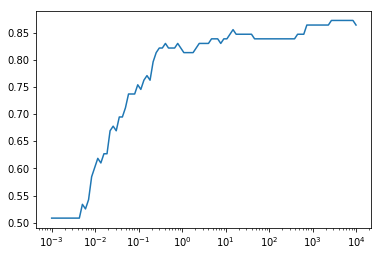

In [61]:
fig, ax = plt.subplots()
plt.plot(cs, accs)
ax.set_xscale('log')

In sklearn, $C$ is the inverse regularization rate (i.e. $C \sim 1/\lambda$). When $C$ is very small, this means that the regularization is actually very strong, this makes the bias term dominate and variance is heavily reduced (the bias/variance tradeoff). For that reason the accuracy is not great. In the opposite limit (large $C$), the regularization is reduced and the model overfits.
<a id="pdo"></a>
# Polynomial Degree and Overfitting

In [62]:
X = np.matrix(data.iloc[:,:-1])

# convert the target variables from the DataFrame into a numpy matrix
# notice that for the Gradient and Cost functions, this NEEDS TO BE A MATRIX mx1
# (for sklearn, it needs to be an array of length m)
y = np.array(data.iloc[:,-1]).T 



poly_orders = range(1,60)
c_strong = 10000 # weak regularization 
c_weak = .01 # weak regularization 

accs_strong = []
accs_weak = []


for p in poly_orders:
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(X)
    
    clf = LogisticRegression(C=c_strong, solver='newton-cg', fit_intercept=False).fit(X_poly, y)
    accs_strong.append(clf.score(X_poly, y))
    
    clf = LogisticRegression(C=c_weak, solver='newton-cg', fit_intercept=False).fit(X_poly, y)
    accs_weak.append(clf.score(X_poly, y))



Text(0, 0.5, 'Accuracy')

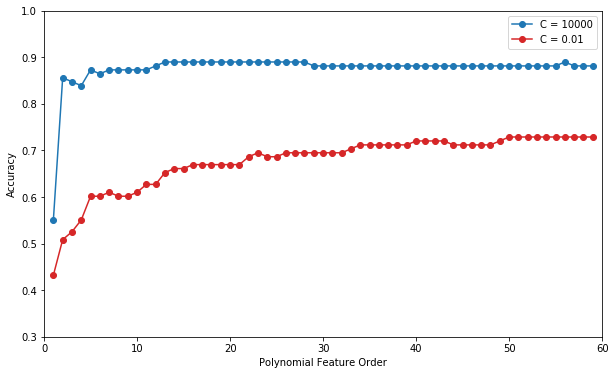

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(poly_orders, accs_strong, '-o', label='C = 10000')
plt.plot(poly_orders, accs_weak, '-o', color=cp[3], label='C = 0.01')
ax.set_xlim((0,60))
ax.set_ylim((.3,1))
ax.legend()
ax.set_xlabel('Polynomial Feature Order')
ax.set_ylabel('Accuracy')